# 🎓 Student Performance Prediction – Regression Models

## Project Goal
The goal of this analysis is to build and compare different regression models 
to predict the final student grade (**G3**) based on demographic, social, and academic features.  

## Why It Matters
By identifying the most important predictors of student performance, 
educators and policymakers can better support students at risk of failing 
and promote positive study habits.

## Models Compared
- Linear Regression (baseline model)  
- Random Forest Regressor (non-linear ensemble model)  
- XGBoost Regressor (gradient boosting, state-of-the-art for tabular data)

## Evaluation Metrics
- **MAE (Mean Absolute Error)** → average absolute prediction error  
- **RMSE (Root Mean Squared Error)** → penalizes large errors  
- **R² (Coefficient of Determination)** → proportion of explained variance  

In [2]:
# =============== 1. Setup ===============
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import numpy as np
import pandas as pd

import xgboost as xgb
from ngboost import NGBRegressor
from ngboost.distns import Normal
import matplotlib
matplotlib.use("Agg")   # headless backend
import matplotlib.pyplot as plt
%matplotlib inline

## Data Preparation
Splitting the dataset into training and test sets, and applying preprocessing 
(OneHotEncoding for categorical features, passthrough for numerical features).

In [3]:
# Features & Target
df = pd.read_csv("../student-mat.csv", sep=";")

X = df.drop(columns=["G3"])
y = df["G3"]

cat_features = X.select_dtypes(include=["object"]).columns
num_features = X.select_dtypes(exclude=["object"]).columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(drop="first", sparse_output=False), cat_features),
        ("num", "passthrough", num_features)
    ]
)


##  Model Training & Evaluation
Three models are trained and evaluated on the test set using MAE, RMSE, and R².


In [4]:
# =============== 2. Models ===============
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=200, random_state=42),
    "XGBoost": xgb.XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=4, random_state=42)}

results = []

# =============== 3. Training & Evaluation ===============
for name, model in models.items():
    pipe = Pipeline(steps=[("preprocessor", preprocessor),
                           ("regressor", model)])
    
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    results.append({"Model": name, "MAE": mae, "RMSE": rmse, "R²": r2})

results_df = pd.DataFrame(results)
display(results_df)

,Model,MAE,RMSE,R²
0,Linear Regression,1.646666,2.378370,0.724134
1,Random Forest,1.190696,1.983077,0.808213
2,XGBoost,1.223413,2.081294,0.788745


## Feature Importance (XGBoost)
To interpret the best-performing model (XGBoost), feature importance values are extracted and visualized.


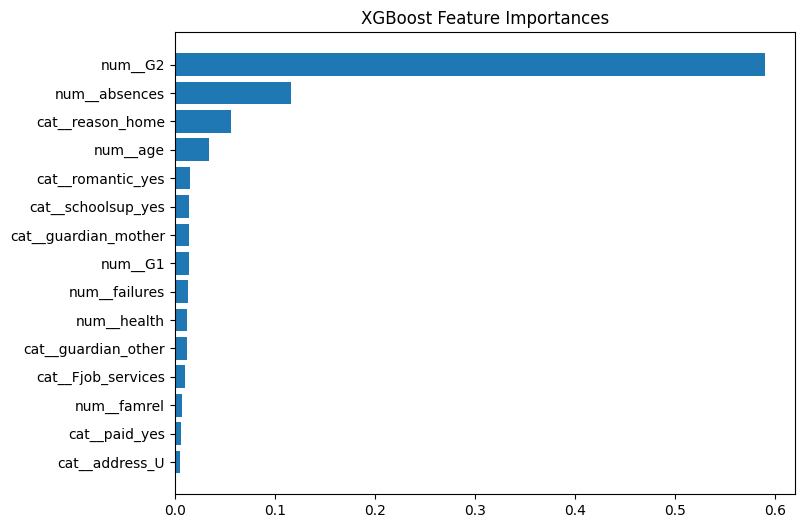

In [5]:
import matplotlib.pyplot as plt

# Train XGBoost separately for feature importance
xgb_model = xgb.XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=4, random_state=42)
xgb_pipe = Pipeline(steps=[("preprocessor", preprocessor),
                           ("regressor", xgb_model)])
xgb_pipe.fit(X_train, y_train)

# Extract feature importance
feature_names = xgb_pipe.named_steps["preprocessor"].get_feature_names_out()
importances = xgb_pipe.named_steps["regressor"].feature_importances_

importance_df = pd.DataFrame({"Feature": feature_names, "Importance": importances})
importance_df = importance_df.sort_values(by="Importance", ascending=False).head(15)

plt.figure(figsize=(8,6))
plt.barh(importance_df["Feature"], importance_df["Importance"])
plt.gca().invert_yaxis()
plt.title("XGBoost Feature Importances")
plt.show()

##  Conclusions

- **RandomForestRegressor** achieved the best performance (highest R², lowest error), outperforming Linear Regression and Suprisingly XGboost.  
- The most influential predictors were **early grades (G1, G2)**, **study time**, and **absences**.  
- This confirms that consistent study habits and early academic performance are strong indicators of final success.  
- **Next Steps**:  
  - Perform hyperparameter tuning (e.g., GridSearchCV) to further optimize XGBoost.  
  - Explore probabilistic models such as **NGBoost** to provide uncertainty estimates for predictions.  
  - Consider deployment of the model (e.g., via Streamlit) for real-world applications.


In [6]:
# Save the trained model to a file
import joblib
joblib.dump(RandomForestRegressor(n_estimators=200), 'regression_model.pkl')

['regression_model.pkl']